In [1]:
!nvidia-smi

Tue Feb 25 04:24:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 570.86.16      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:2B:00.0 Off |                  N/A |
| 34%   49C    P8             16W /  165W |      88MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear, sie

sns.set_style("whitegrid")
tfd = tfp.distributions

2025-02-25 04:24:42.295713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740428682.312663  104608 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740428682.318221  104608 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 04:24:42.336020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.Uniform(0.001, 3.001),
                e1=tfd.TruncatedNormal(0, 0.3, -1.0, 1.0),
                e2=tfd.TruncatedNormal(0, 0.3, -1.0, 1.0),
                center_x=tfd.Normal(0, 0.1),
                center_y=tfd.Normal(0, 0.1),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Uniform(-0.2, 0.2), gamma2=tfd.Uniform(-0.2, 0.2))
        ),
    ]
)

truncated_lognormal = tfd.TransformedDistribution(
    distribution=tfd.TruncatedNormal(
        loc=tf.math.log(500.0),
        scale=0.3,
        low=tf.math.log(0.001),
        high=tf.math.log(1000.0)
    ),
    bijector=tfp.bijectors.Exp()
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.Uniform(0.001, 2.001), 
                n_sersic=tfd.Normal(4.0, 0.5),
                e1=tfd.TruncatedNormal(0, 0.3, -1.0, 1.0),
                e2=tfd.TruncatedNormal(0, 0.3, -1.0, 1.0),
                center_x=tfd.Normal(0, 0.1),
                center_y=tfd.Normal(0, 0.1),
                Ie=truncated_lognormal,
            )
        )
    ]
)


truncated_lognormal = tfd.TransformedDistribution(
    distribution=tfd.TruncatedNormal(
        loc=tf.math.log(150.0),
        scale=0.3,
        low=tf.math.log(0.001),
        high=tf.math.log(1000.0)
    ),
    bijector=tfp.bijectors.Exp()
)
source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.Uniform(0.001, 2.001), 
                n_sersic=tfd.Uniform(0.3, 2.3),
                e1=tfd.TruncatedNormal(0, 0.3, -1.0, 1.0),
                e2=tfd.TruncatedNormal(0, 0.3, -1.0, 1.0),
                center_x=tfd.Normal(0, 0.5),
                center_y=tfd.Normal(0, 0.5),
                Ie=truncated_lognormal,
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

I0000 00:00:1740428684.064552  104608 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14206 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.9


In [4]:
prior.sample(2)

[[{'theta_E': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.4164073, 2.8675084], dtype=float32)>,
   'e2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.44498584,  0.06721684], dtype=float32)>,
   'e1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.15482235, 0.6709577 ], dtype=float32)>,
   'center_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.02744198, -0.07507111], dtype=float32)>,
   'center_x': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.03357013,  0.03687131], dtype=float32)>},
  {'gamma2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.11254831, -0.0638103 ], dtype=float32)>,
   'gamma1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.13145103, -0.08328252], dtype=float32)>}],
 [{'n_sersic': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.1034894, 4.075507 ], dtype=float32)>,
   'e2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.33473432, -0.39210153], dtype=float32)>,
   'e1': <tf.Tensor: shape=(2,)

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [6]:
import gigalens
from astropy.io import fits

kernel = fits.getdata('data/psf.fits').astype(np.float32)
observed_img = fits.getdata('data/image.fits').astype(np.float32)

sim_config = SimulatorConfig(delta_pix=0.074, num_pix=len(observed_img), supersample=2, kernel=kernel)
phys_model = PhysicalModel([sie.SIE(), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.1, exp_time=300)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

I0000 00:00:1740428685.755730  104608 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0xd65e9d0


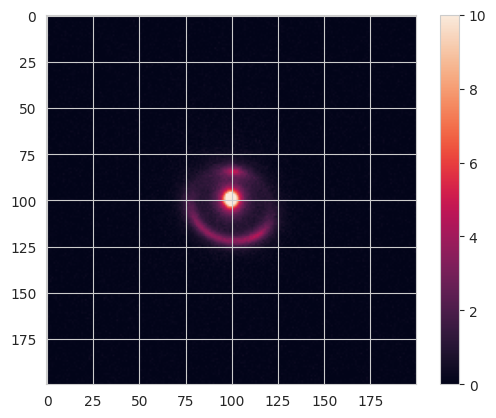

In [7]:
plt.imshow(observed_img, vmin=0, vmax=10)
plt.colorbar()

Sanity check: calculate residuals using ground truth.

Begin fitting. We use `supersample=1` for this demonstration to speed things up, but setting `supersample=2` is recommended in practice. This will not significantly slow down the fitting.

In [9]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

In [10]:
n_map = 50
n_step = 1000
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, n_step, 1e-2/n_step)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=n_map, num_steps=n_step, seed=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
lens_sim_n_MAP = LensSimulator(phys_model, sim_config, bs=n_map)
lps = prob_model.log_prob(lens_sim_n_MAP, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

In [14]:
best

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([ 2.2795303e-03,  1.6902596e-03, -9.0661950e-02, -1.3230358e-02,
        1.5044628e-03,  5.4883033e-01,  4.6120295e-01,  1.9288116e+00,
        8.0498151e-02, -1.6399065e-04,  4.4004869e-04, -9.8084062e-02,
        8.4058978e-03,  4.0285869e+00,  1.9945092e+00, -1.7754558e+00,
        6.1612222e-03,  3.0220035e-01,  8.2961068e-02,  1.2022453e-01,
       -7.2700536e-01], dtype=float32)>

In [19]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=100, num_steps=1000)

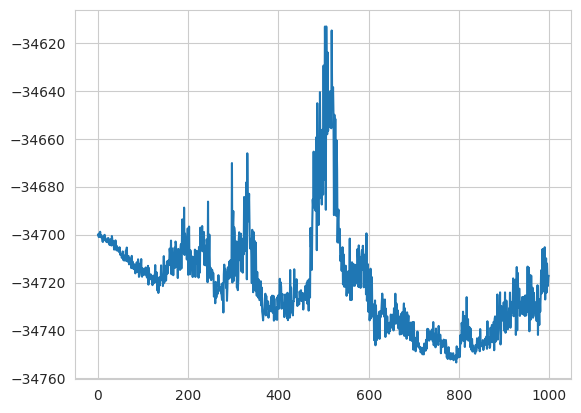

In [20]:
plt.plot(losses)

Although the loss is still declining, the VI results are sufficient for our sampling.

In [21]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/home/cao/anaconda3/envs/gigalens/lib/python3.10/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [22]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[1.0008737  1.0018388  1.0006273  1.0101706  1.0027163  1.0005951
 1.0112255  1.0693188  1.0744152  1.0007521  1.0008588  1.0000057
 1.0017408  1.0545211  1.0099224  1.0226548  1.0026888  1.0010805
 0.99975353 1.0045512  1.0125133 ] [21544.55   15435.374  15845.7705  4608.2417 25331.484  16787.418
  3890.641    723.4368   684.0187 29668.299  28862.447  30394.846
 27116.193    898.05   28005.83    2109.2065 12438.752  24248.527
 27787.266   9670.744   3660.5686]


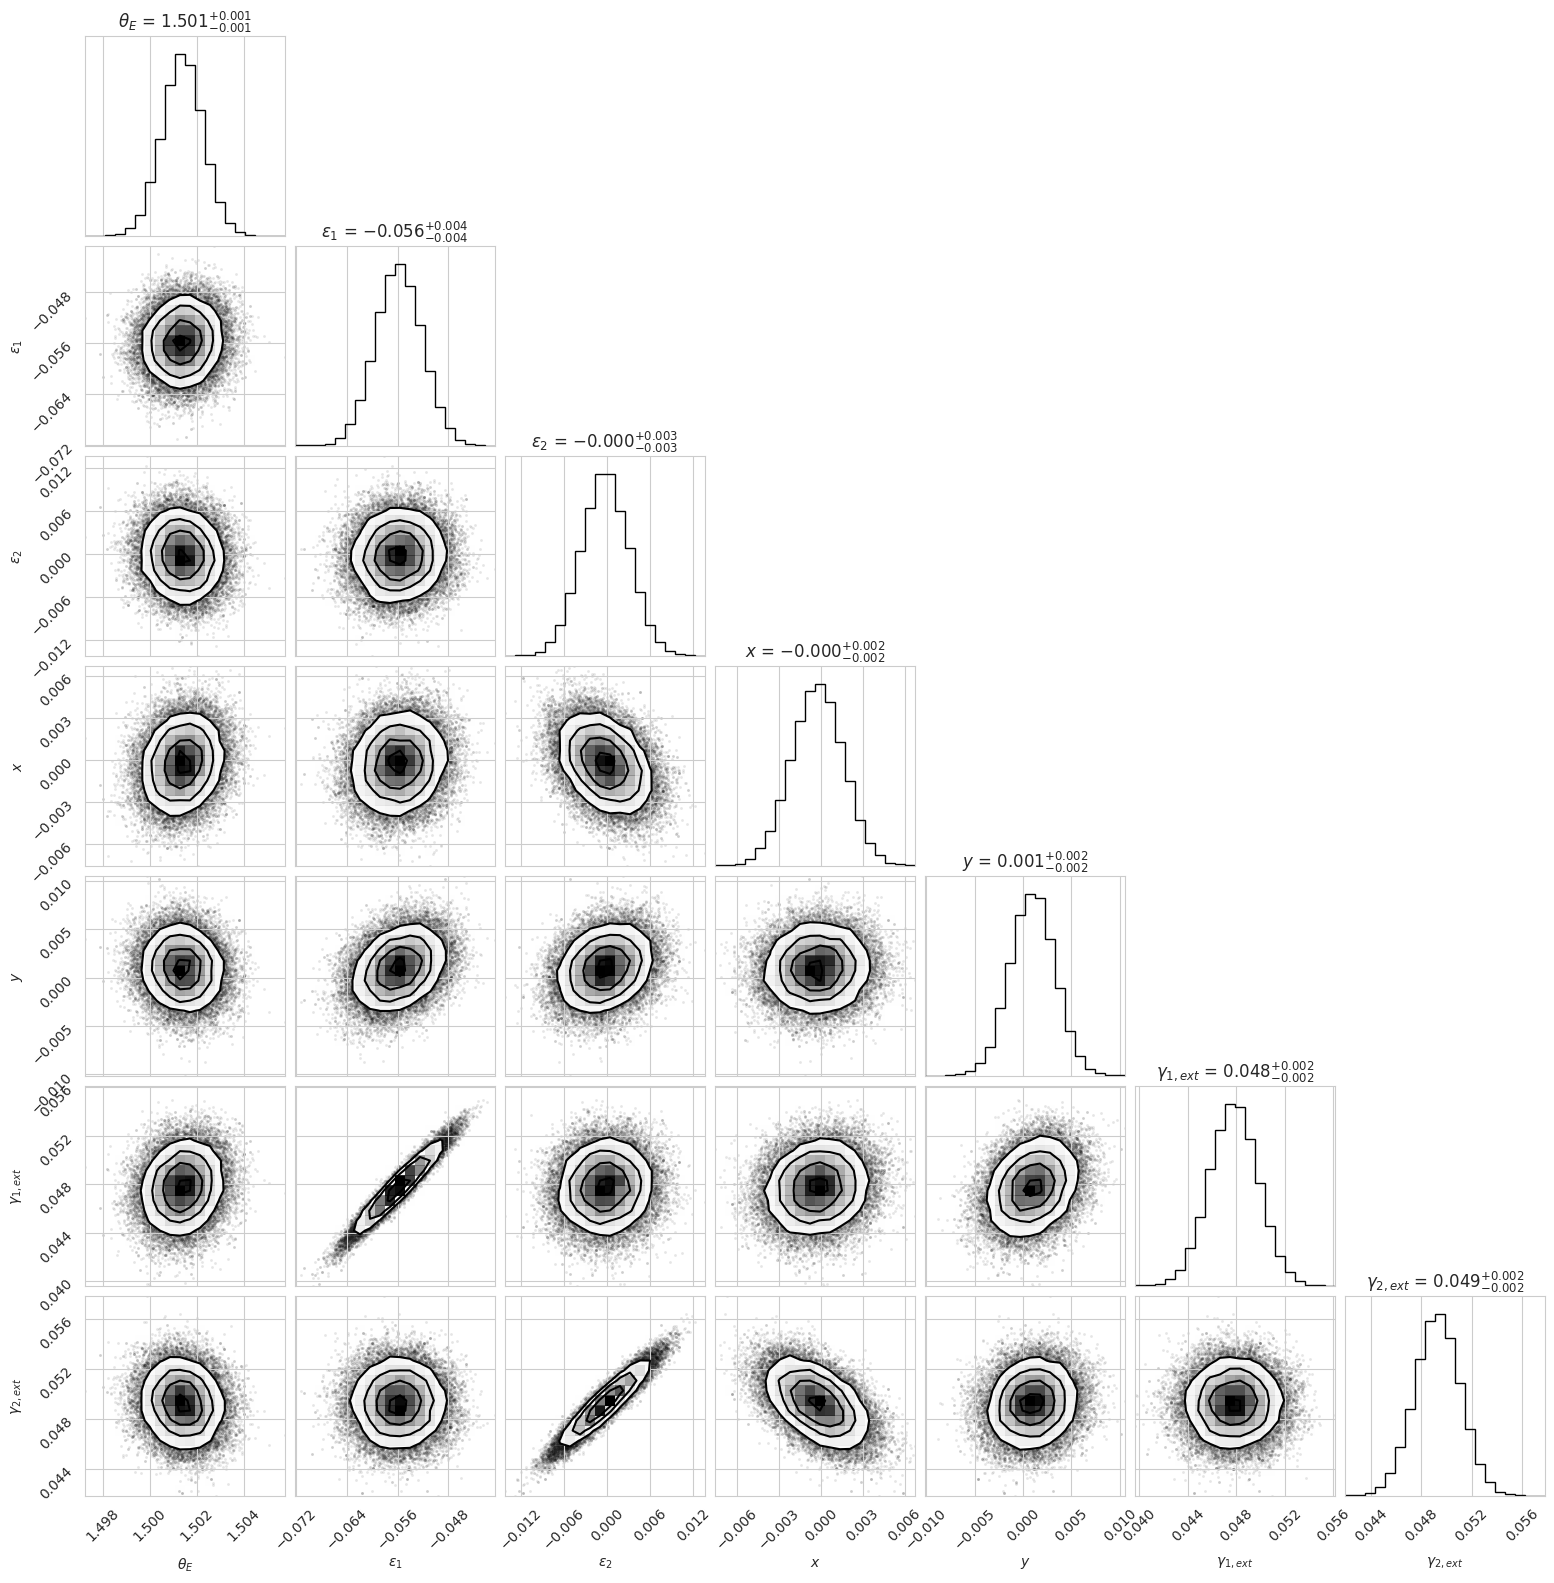

In [23]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[0][1]['gamma1'],
    x[0][1]['gamma2'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
corner(physical_samples.reshape((7,-1)).T, 
       show_titles=True, title_fmt='.3f',
       labels=[r'$\theta_E$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$']);